In [86]:
import re
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# First Exploration
This notebook contains a first (brief) exploration of the stackexchange data (including our hand-engineered features)
along with some first attempts at a predictive model.

In [2]:
datapath = "Dataset"

df = pd.concat([
    pd.read_csv(os.path.join(datapath, p))
    for p in os.listdir(datapath)
    if p.endswith(".csv")
]).reset_index(drop=True)

print(df.shape)

df.head()

(160540, 21)


,folder,id,body,title,n_links,n_tags,n_lists,n_views,time,n_answers,...,time_til_first_answer,y,num_question_marks,wh_word_count,sentence_count,word_count,example_count,n_linebreaks,title_word_count,title_question_marks
0,Data/android.stackexchange.com,1,This is a common question by those who have ju...,I've rooted my phone. Now what? What do I ga...,0,2,0,477272,2010-09-13 19:16:26.763,3,...,0.103480,8958.276850,2,3,4,29,0,1,13,2
1,Data/android.stackexchange.com,2,I have a Google Nexus One with Android 2.2. I ...,"I installed another SMS application, now I get...",0,4,0,1233,2010-09-13 19:17:17.917,3,...,0.034801,1034.457987,1,2,4,36,0,1,10,0
2,Data/android.stackexchange.com,5,I have a Motorola DROID v1 that is running Fro...,Moto Droid v1 disabling primary Wireless AP,0,1,0,312,2010-09-13 19:19:35.360,1,...,4112.699605,0.001459,1,3,6,101,0,2,7,0
3,Data/android.stackexchange.com,8,I would like to send two contacts (name+phone ...,How do I send a contact via SMS?,0,2,0,50115,2010-09-13 19:21:03.273,12,...,0.120577,1094.736648,1,1,4,49,0,3,8,1
4,Data/android.stackexchange.com,9,Does one really need to install a task manager...,Do I really need to install a task manager?,0,1,0,20836,2010-09-13 19:21:10.473,7,...,0.049335,13621.084755,1,0,2,25,0,1,9,1


In [3]:
for i in df.index[:6]:
    row = df.loc[i]
    for i in row.index:
        print(i, " -- ", row[i])
    
    print("=" * 50)

folder  --  Data/android.stackexchange.com
id  --  1
body  --  This is a common question by those who have just rooted their phones.  What apps, ROMs, benefits, etc. do I get from rooting?  What should I be doing now?

title  --  I've rooted my phone.  Now what?  What do I gain from rooting?
n_links  --  0
n_tags  --  2
n_lists  --  0
n_views  --  477272
time  --  2010-09-13 19:16:26.763
n_answers  --  3
score  --  308
time_til_first_answer  --  0.10347972222222222
y  --  8958.276849731697
num_question_marks  --  2
wh_word_count  --  3
sentence_count  --  4
word_count  --  29
example_count  --  0
n_linebreaks  --  1
title_word_count  --  13
title_question_marks  --  2
folder  --  Data/android.stackexchange.com
id  --  2
body  --  I have a Google Nexus One with Android 2.2. I didn't like the default SMS-application so I installed Handcent-SMS. Now when I get an SMS, I get notified twice. How can I fix this?

title  --  I installed another SMS application, now I get notified twice
n_link

## Variable Histograms

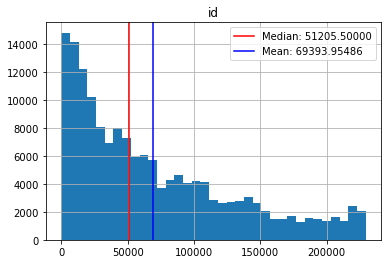

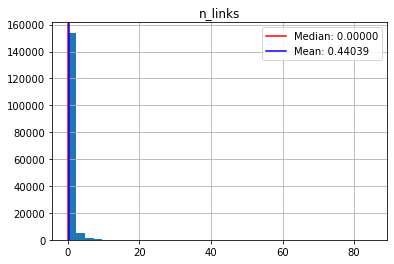

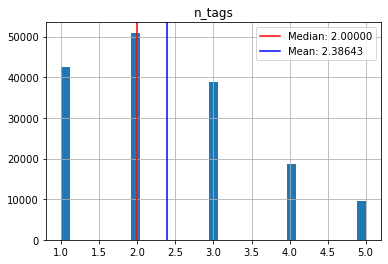

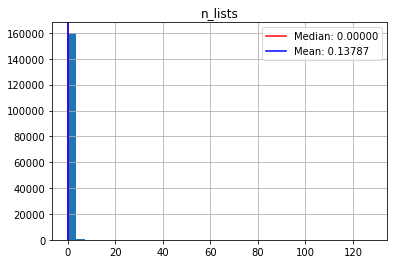

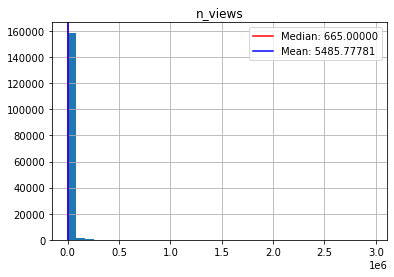

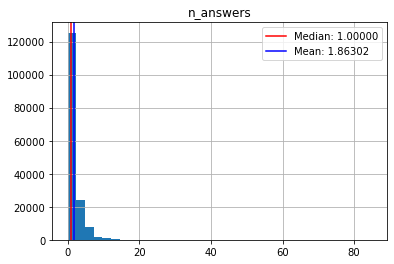

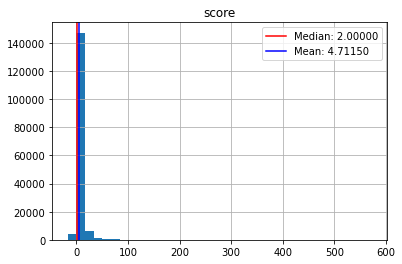

BAD time_til_first_answer


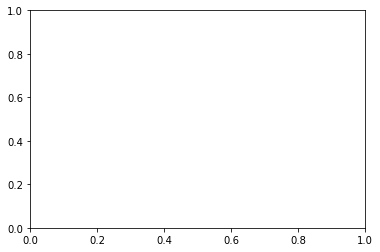

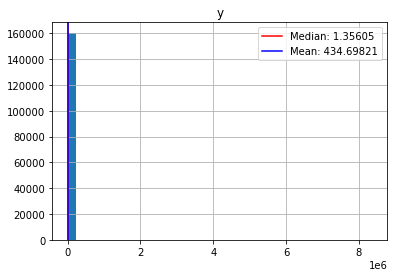

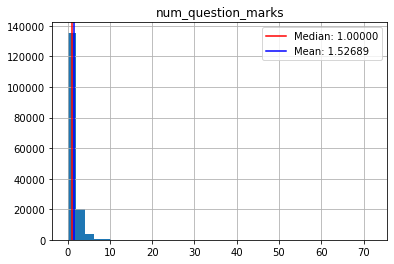

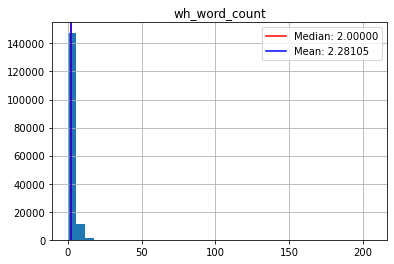

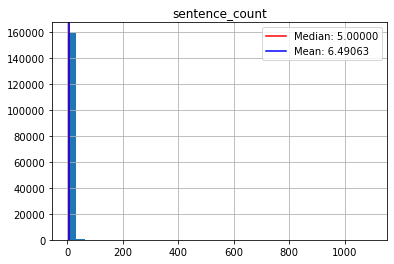

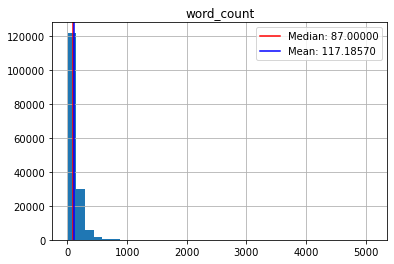

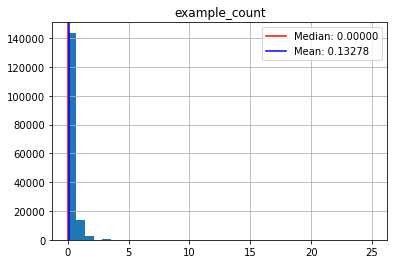

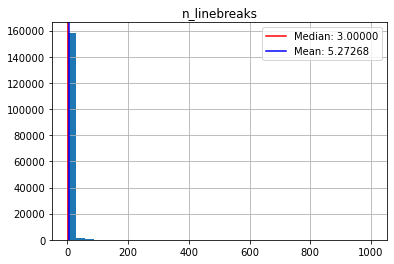

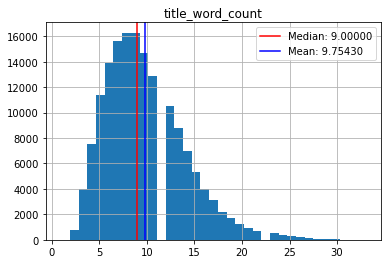

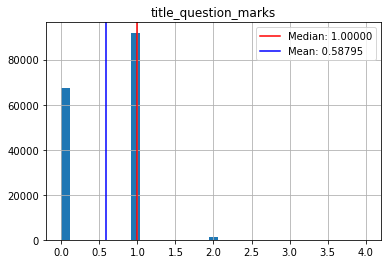

In [4]:
for c in df.columns:
    if df.dtypes[c] == "object":
        continue
    
    try:
        fig, ax = plt.subplots()
        df[c].dropna().hist(ax=ax, bins=35)
        ax.set_title(c)
        medianval = df[c].median()
        ax.axvline(medianval, color="red", label=f"Median: {medianval:0.5f}")

        meanval = df[c].mean()
        ax.axvline(meanval, color="blue", label=f"Mean: {meanval:0.5f}")
        ax.legend()
    #     fig.savefig(f"Histogram_{c}.png")
        plt.show()
    except:
        print("BAD", c)

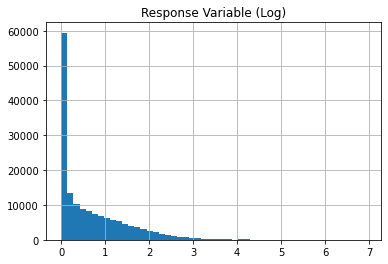

In [13]:
fig, ax = plt.subplots()
np.log10(1 + df.y).hist(bins=50, ax=ax)
ax.set_title("Response Variable (Log)")
plt.show()

In [6]:
df.y.min(), df.y.max(), df.y.mean(), df.y.median()

(0.0, 8359200.0, 434.6982108428378, 1.3560469098213845)

## Comment on histograms
After a first glance at these histograms we can see that many of our hand-engineered features are concentrated around 0 but many
of them have very long tails with extreme outliers. This is particularly concerning when it comes to our response variable. One
possible way to fix this would be to use logarithmic trainsforms. First, however, we will try some simple models.

In [7]:
print(df.columns)

Index(['folder', 'id', 'body', 'title', 'n_links', 'n_tags', 'n_lists',
       'n_views', 'time', 'n_answers', 'score', 'time_til_first_answer', 'y',
       'num_question_marks', 'wh_word_count', 'sentence_count', 'word_count',
       'example_count', 'n_linebreaks', 'title_word_count',
       'title_question_marks'],
      dtype='object')


In [65]:
FEATURES = [
    "wh_word_count",
    "sentence_count",
    "word_count",
    "example_count",
    "n_linebreaks",
    "title_word_count",
    "title_question_marks",
    "n_links",
    "n_tags",
    "n_lists"
]


x = df[FEATURES]
y = df["y"]

# y = np.log10(1 + df.y)

print(y.head())
x.head()

0     8958.276850
1     1034.457987
2        0.001459
3     1094.736648
4    13621.084755
Name: y, dtype: float64


,wh_word_count,sentence_count,word_count,example_count,n_linebreaks,title_word_count,title_question_marks,n_links,n_tags,n_lists
0,3,4,29,0,1,13,2,0,2,0
1,2,4,36,0,1,10,0,0,4,0
2,3,6,101,0,2,7,0,0,1,0
3,1,4,49,0,3,8,1,0,2,0
4,0,2,25,0,1,9,1,0,1,0


In [66]:
np.random.seed(852)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)

print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)


pipe = make_pipeline(StandardScaler(), Lasso(alpha=7.5), verbose=True)

pipe.fit(xtrain, ytrain)

(120405, 10) (40135, 10)
(120405,) (40135,)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=7.5))],
         verbose=True)

In [67]:
print("Ytrain Variance:")
print(np.var(ytrain))

print("Ytest Variance:")
print(np.var(ytest))

train_pred = pipe.predict(xtrain)

train_mae = mean_absolute_error(y_true=ytrain, y_pred=train_pred)
train_mse = mean_squared_error(y_true=ytrain, y_pred=train_pred)

print("Train set performance:")
print("MSE: ", train_mse)
print("MAE: ", train_mae)

test_pred = pipe.predict(xtest)

test_mae = mean_absolute_error(y_true=ytest, y_pred=test_pred)
test_mse = mean_squared_error(y_true=ytest, y_pred=test_pred)

print("Test set performance:")
print("MSE: ", test_mse)
print("MAE: ", test_mae)

Ytrain Variance:
705726503.9097315
Ytest Variance:
329602593.93498766
Train set performance:
MSE:  705596603.3709772
MAE:  797.7930797597558
Test set performance:
MSE:  329359744.0915645
MAE:  853.4847207350356


In [68]:
print("Train MAE for constant model:")
np.mean(np.abs(ytrain - np.median(ytrain)))

print("Test MAE for constant model:")
np.mean(np.abs(ytest - np.median(ytrain)))

Train MAE for constant model:
Test MAE for constant model:


479.90092705741824

In [69]:
coeff = pd.DataFrame({
    "variable": x.columns,
    "coefficient": pipe[1].coef_
}).sort_values(by="coefficient")

coeff

,variable,coefficient
2,word_count,-204.752583
1,sentence_count,-49.857218
9,n_lists,-29.724079
6,title_question_marks,-4.936201
3,example_count,-0.000000
8,n_tags,57.247762
4,n_linebreaks,70.106381
7,n_links,186.905207
0,wh_word_count,203.985181
5,title_word_count,225.467226


## Lasso model review
Our first model (Lasso) leaves a lot to wish for when it comes to performance (it performs even worse than a constant model wrt MAE), which
points to the fact that we still have a very basic set of features without really diving deep into the text. Perhaps our response
variable could also use some work. Next we try a Lasso with the question score as response variable.

In [74]:
x = df[FEATURES]
y = df["score"]

# y = np.log10(1 + df.y)

np.random.seed(852)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)

print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)


pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.1), verbose=True)

pipe.fit(xtrain, ytrain)

(120405, 10) (40135, 10)
(120405,) (40135,)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.0s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1))],
         verbose=True)

In [75]:
print("Ytrain Variance:")
print(np.var(ytrain))

print("Ytest Variance:")
print(np.var(ytest))

train_pred = pipe.predict(xtrain)

train_mae = mean_absolute_error(y_true=ytrain, y_pred=train_pred)
train_mse = mean_squared_error(y_true=ytrain, y_pred=train_pred)

print("Train set performance:")
print("MSE: ", train_mse)
print("MAE: ", train_mae)

test_pred = pipe.predict(xtest)

test_mae = mean_absolute_error(y_true=ytest, y_pred=test_pred)
test_mse = mean_squared_error(y_true=ytest, y_pred=test_pred)

print("Test set performance:")
print("MSE: ", test_mse)
print("MAE: ", test_mae)

Ytrain Variance:
96.7602297084709
Ytest Variance:
95.01652415438039
Train set performance:
MSE:  92.60224029368882
MAE:  4.550397486594201
Test set performance:
MSE:  90.8927707342548
MAE:  4.541340782307818


In [76]:
print("Train MAE for constant model:")
np.mean(np.abs(ytrain - np.median(ytrain)))

print("Test MAE for constant model:")
np.mean(np.abs(ytest - np.median(ytrain)))

Train MAE for constant model:
Test MAE for constant model:


4.065678335617291

In [77]:
coeff = pd.DataFrame({
    "variable": x.columns,
    "coefficient": pipe[1].coef_
}).sort_values(by="coefficient")

coeff

,variable,coefficient
4,n_linebreaks,-0.606804
7,n_links,-0.000000
1,sentence_count,0.056656
5,title_word_count,0.099631
8,n_tags,0.111287
9,n_lists,0.111832
3,example_count,0.118829
0,wh_word_count,0.323971
2,word_count,1.139213
6,title_question_marks,1.301604


## Lasso - score review
Once again, model performance is not particularly impressive, but the scale of the score variable is more stable than that of our
other response variable. It is also notable that some variables' coefficients have different signs in both models. Now we try a simple
classification.

In [84]:
thresh = 2

x = df[FEATURES]
y = df["score"] > thresh
print(np.mean(y))

# y = np.log10(1 + df.y)

np.random.seed(852)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)

print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)


pipe = make_pipeline(StandardScaler(), LogisticRegression(), verbose=True)

pipe.fit(xtrain, ytrain)

0.4575246044599477
(120405, 10) (40135, 10)
(120405,) (40135,)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.2s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())],
         verbose=True)

In [90]:
train_pred = pipe.predict(xtrain)

train_acc = accuracy_score(y_true=ytrain, y_pred=train_pred)
train_mat = confusion_matrix(y_true=ytrain, y_pred=train_pred)

print("Train set performance:")
print("Accuracy: ", train_acc)
print("Confusion matrix: \n", train_mat)
print()

test_pred = pipe.predict(xtest)

test_acc = accuracy_score(y_true=ytest, y_pred=test_pred)
test_mat = confusion_matrix(y_true=ytest, y_pred=test_pred)

print("Test set performance:")
print("Accuracy: ", test_acc)
print("Confusion matrix: \n", test_mat)

Train set performance:
Accuracy:  0.6030812673892281
Confusion matrix: 
 [[42219 23180]
 [24611 30395]]

Test set performance:
Accuracy:  0.6032141522362028
Confusion matrix: 
 [[14061  7629]
 [ 8296 10149]]


In [92]:
coeff = pd.DataFrame({
    "variable": x.columns,
    "coefficient": pipe[1].coef_.flatten()
}).sort_values(by="coefficient")

coeff

,variable,coefficient
4,n_linebreaks,-0.281900
5,title_word_count,-0.056431
0,wh_word_count,-0.007446
8,n_tags,-0.004096
1,sentence_count,0.032654
7,n_links,0.062036
3,example_count,0.068457
9,n_lists,0.087857
2,word_count,0.289459
6,title_question_marks,0.428805


# Logistic Regression review
The classification problem seemed to fare a little better than the regressions, with an accuracy slightly better than
a random or constant output. It is also comforting to see that the confusion matrices have a dominant diagonal.